In [1]:
import pandas as pd
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import  linear_model
from sklearn.svm import SVC
import tensorflow as tfl
from sklearn.feature_extraction.text import TfidfVectorizer

2022-07-23 23:37:35.489696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-23 23:37:35.489761: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data = pd.read_csv("emails.csv")

<AxesSubplot:>

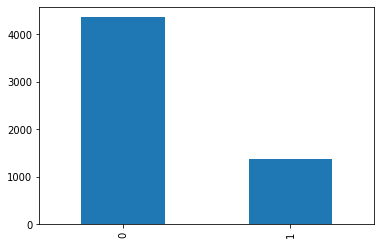

In [3]:
data['spam'].value_counts().plot(kind='bar')

The data contains more than twice the amount of nonspam than spam

In [4]:
#data["length"] = data["text"].apply(len)


preprocessing the data

In [3]:
prep_data=data
#to lower case
prep_data['text']=prep_data['text'].apply(str.lower)

#remove urls
prep_data['text']=prep_data['text'].replace('((www\.[\s]+)|(https?://[^\s]+))','URL',regex=True)

#remove digits and special chars
prep_data['text']=prep_data['text'].replace(["\W","\s","\d"],' ',regex=True)




In [6]:
#remove stopwords


stop =set(stopwords.words('english'))
prep_data['text'] = prep_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [7]:
#tokenize
prep_data['text'] = prep_data['text'].apply(word_tokenize)

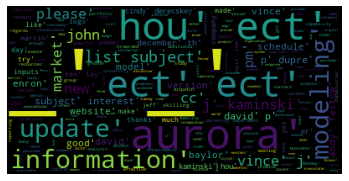

In [8]:
wc_input = prep_data['text'].values

wc = WordCloud().generate(str( wc_input ))
plt.imshow(wc)
plt.axis("off")
plt.show()

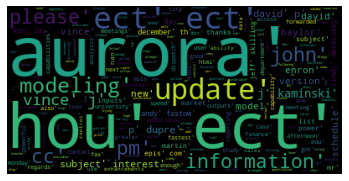

In [9]:
wc = WordCloud().generate(str( prep_data['text'].where(cond=prep_data['spam']==0).values ))
plt.imshow(wc)
plt.axis("off")
plt.show()

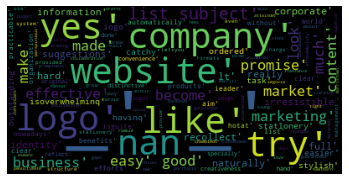

In [10]:
wc = WordCloud().generate(str( prep_data['text'].where(cond=prep_data['spam']==1).values ))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [11]:

corpus= set() #words that appear in the data 
for i in prep_data['text']:
    corpus.update(i)

total_number_of_words =0
for x in prep_data['text']:
    total_number_of_words += len(x)

tf = {} #TF(word, document) = “number of occurrences of the word in the document” / “number of words in the document”
idf= {} #    IDF(word) = log(number of documents / number of documents that contain the word)
tf_idf= {} #TF*IDF
number_of_documents = len(prep_data.index)

for word in corpus:
    tf[word]=0
    for i in prep_data['text']:
        tf[word]= tf[word]+i.count(word)
    tf[word]=tf[word]/total_number_of_words

    idf[word]=0
    for j in prep_data['text']:
        if word in j :
            idf[word] +=1
    idf[word]=math.log(number_of_documents / idf[word])

    tf_idf[word]= tf[word]*idf[word]




In [12]:
max_len = len(max(prep_data['text'],key=len))
max_len

4122

In [13]:
def encode(words ,max_padding_size,encoder):
    encoded_words=[]
    for word in words:
        encoded_words.append(encoder.get(word))

    return encoded_words + ([0]*(max_padding_size-len(encoded_words)))
         


In [14]:
    tmp= []
    for x in prep_data['text']:
        tmp.append(encode(words=x,max_padding_size=max_len,encoder=tf_idf))
    
    prep_data['encoded_text']=tmp
    #prep_data['encoded_text'] = encode(words=prep_data['text'],max_padding_size=max_len,encoder=tf_idf)

In [15]:
#the dataframe needs to be reformatted so the encoded_text colum can fit into the model
input_data=pd.DataFrame(prep_data['encoded_text'].values.tolist())
input_data.columns = input_data.columns.map(str)
input_data=input_data.drop(columns=['0'])#this can be removed because it is always 0.0 cuz all emailtext in the dataset starts with Subject


In [16]:
X_train, X_test, y_train, y_test = train_test_split(input_data,prep_data['spam'], test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(4582, 4121) (4582,)
(1146, 4121) (1146,)


In [17]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
lm.score(X_test,y_test)

-5.676202830834714e+20

In [18]:
clf = SVC(kernel='linear').fit(X_train, y_train)
clf.score(X_test,y_test)

0.7678883071553229

In [19]:
lm.score(X_test,y_test)

-5.676202830834714e+20

In [22]:
model =tfl.keras.models.Sequential([
    tfl.keras.layers.Dense(8242,input_shape=(4121,), activation='relu'),
    tfl.keras.layers.Dropout(0.2),
    tfl.keras.layers.Dense(8242, activation='relu'),
    tfl.keras.layers.Dense(1,activation='linear')
])

model.compile(optimizer='adam',
              loss='BinaryCrossentropy',
              metrics=['BinaryAccuracy'])


2022-07-17 01:56:20.024840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-17 01:56:20.024865: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-17 01:56:20.024885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (roger-ThinkPad-L590): /proc/driver/nvidia/version does not exist
2022-07-17 01:56:20.025434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
callback = tfl.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train,y_train,batch_size=30,epochs=170,validation_data=(X_test, y_test),verbose=1,callbacks=[callback])

# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)

Epoch 1/170
153/153 [==============================] - 173s 1s/step - loss: 0.6162 - binary_accuracy: 0.7545 - val_loss: 0.4429 - val_binary_accuracy: 0.7705
Epoch 2/170
153/153 [==============================] - 179s 1s/step - loss: 0.4197 - binary_accuracy: 0.7990 - val_loss: 0.4269 - val_binary_accuracy: 0.8002
Epoch 3/170
153/153 [==============================] - 179s 1s/step - loss: 0.4524 - binary_accuracy: 0.7831 - val_loss: 0.3960 - val_binary_accuracy: 0.8072
Epoch 4/170
153/153 [==============================] - 192s 1s/step - loss: 0.4209 - binary_accuracy: 0.8263 - val_loss: 0.4267 - val_binary_accuracy: 0.8054
Epoch 5/170
153/153 [==============================] - 196s 1s/step - loss: 0.5019 - binary_accuracy: 0.7887 - val_loss: 0.4192 - val_binary_accuracy: 0.7723
Epoch 6/170
153/153 [==============================] - 200s 1s/step - loss: 0.3909 - binary_accuracy: 0.8180 - val_loss: 0.4611 - val_binary_accuracy: 0.8133
Epoch 7/170
153/153 [==============================]